In [44]:
import cv2
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.decomposition import MiniBatchDictionaryLearning
from itertools import product

import matplotlib.pyplot as plt
#%matplotlib inline

In [3]:
def extract_patches(arr, patch_shape, max_patches = None, extraction_step=1):
    
    i_h, i_w = arr.shape[:2]
    p_h, p_w, channels = patch_shape
    
    arr_ndim = arr.ndim

    extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    if max_patches:
        i_s = np.random.randint(i_h - p_h + 1, size=max_patches)
        j_s = np.random.randint(i_w - p_w + 1, size=max_patches)
        patches = patches[i_s, j_s, 0]
    
    return patches

In [29]:
img = cv2.imread('picasso/Self_Picasso.jpg')

In [37]:
data = extract_patches(img/255, (8,8, 3), max_patches=1000)
data = data.reshape(data.shape[0], -1)
mean = np.mean(data, axis=0)
data -= mean
data /= np.std(data, axis=0)

In [59]:
print('Size of Dictionary: ', data.shape)

Size of Dictionary:  (1000, 192)


In [38]:
dic = MiniBatchDictionaryLearning(n_components=256, alpha=1, n_iter=500)
v = dic.fit(data).components_

Wall time: 0 ns


In [39]:
patch_size = (8,8,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

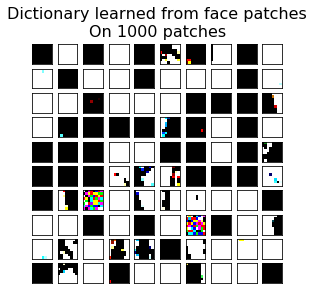

In [34]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(v[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size)*255, cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'On %d patches' % (len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


In [46]:
def reconstruct_from_patches(patches, image_size):
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, product(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p

    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            img[i, j] /= float(min(i + 1, p_h, i_h - i) *
                               min(j + 1, p_w, i_w - j))
    return img

In [36]:
dic.set_params(transform_algorithm='omp')

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=256, n_iter=500,
              n_jobs=None, positive_code=False, positive_dict=False,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=None, verbose=False)

In [41]:
code = dic.transform(data)
patches = np.dot(code, v)

patches += mean
patches = patches.reshape(len(data), *patch_size)

In [47]:
rec_image = reconstruct_from_patches(
        patches, img.shape)

In [57]:
def show_with_diff(image, reference, title):
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


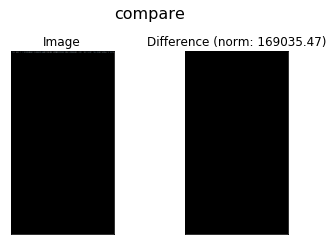

In [58]:
show_with_diff(rec_image, img,
                   'compare')